In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import os
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

In [19]:
nltk.download('twitter_samples')
nltk.download('stopwords')
stopwords_engligh = stopwords.words('english')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/ldoddi/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ldoddi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
data = pd.read_csv('s3://twitter-sentiment-laks/raw/tweets_TWTR_2022.csv',on_bad_lines='skip')

In [46]:
tweet = data["text"][0]

In [47]:
data.columns

Index(['tweet_id', 'created_at', 'text', 'author_id'], dtype='object')

In [48]:
df = data[['tweet_id', 'created_at', 'text', 'author_id']]
df.head()

,tweet_id,created_at,text,author_id
0,1.58796E+18,2022-11-02 23:55:31+00:00,“Because it’s not worth it ($8)” #TWTR https:/...,16577908
1,1.58796E+18,2022-11-02 23:50:01+00:00,Now that #twtr proved to become the worlds pre...,1402496550
2,1.58795E+18,2022-11-02 23:45:54+00:00,RT @emrahvsibel: #GLCVY #tsla #aapl #nvda #twt...,1.1109E+18
3,1.58795E+18,2022-11-02 23:36:29+00:00,$TSLA. #Elon great job keeping everyone busy w...,1.24308E+18
4,1.58795E+18,2022-11-02 23:27:35+00:00,OR\n- buy $8 worth of $XPR\n- create a #webaut...,1.49151E+18


In [49]:
data.shape

(10199, 4)

In [50]:
#Convering data frame coliumn to string
df = df.astype({'text':'string'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10199 entries, 0 to 10198
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    10199 non-null  object
 1   created_at  10199 non-null  object
 2   text        10199 non-null  string
 3   author_id   10199 non-null  object
dtypes: object(3), string(1)
memory usage: 318.8+ KB


## Preprocessing Steps

 - Deleted the missed rows
 - Lowercase
 - Remove punctuations, urls,name
 - Remove stop words
 - Stemming/ Lemmatization
 - Tokenize Sentences



In [51]:
# Delete the missed data rows
df.isnull().sum()
df.dropna(inplace=True)

In [52]:
#Stemming the tweets

In [53]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    tweet2 = re.sub(r'^RT[\s]+','', tweet)
   
    #remove hyperlinks
    tweet2 = re.sub(r'https?://[^\s\n\r]+', '', tweet2)
    
    #remove hashtag by removing the hast #sign from the word
    tweet2 = re.sub(r'#','',tweet2)
    
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    #convert into lower case
    tweets_clean = tweet.lower()
    
    #tokenize the sentences and make it lower case
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet2)
    
    #stemming and removing the punctuation
    tweets_clean = []
    for word in tweet_tokens:
        if(word not in stopwords_engligh and  
            word not in string.punctuation):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    return tweets_clean

In [54]:
#Added column clean_tweet to store te processed tweets 
df['clean_tweet'] = df['text'].map(lambda x : process_tweet(x))

In [55]:
df.head()

,tweet_id,created_at,text,author_id,clean_tweet
0,1.58796E+18,2022-11-02 23:55:31+00:00,“Because it’s not worth it ($8)” #TWTR https:/...,16577908,"[“, ’, worth, 8), ”, twtr]"
1,1.58796E+18,2022-11-02 23:50:01+00:00,Now that #twtr proved to become the worlds pre...,1402496550,"[twtr, prove, becom, world, premier, lib, own,..."
2,1.58795E+18,2022-11-02 23:45:54+00:00,RT @emrahvsibel: #GLCVY #tsla #aapl #nvda #twt...,1.1109E+18,"[glcvi, tsla, aapl, nvda, twtr, msft, amzn, am..."
3,1.58795E+18,2022-11-02 23:36:29+00:00,$TSLA. #Elon great job keeping everyone busy w...,1.24308E+18,"[tsla, elon, great, job, keep, everyon, busi, ..."
4,1.58795E+18,2022-11-02 23:27:35+00:00,OR - buy $8 worth of $XPR - create a #webauth ...,1.49151E+18,"[buy, 8, worth, xpr, creat, webauth, wallet, g..."


### Generating the word cloud from Tweets


In [60]:
mask = np.array(Image.open(r'../images/twitter-black.png'))

In [61]:
# Create function to generate the blue colour for the Word CLoud
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

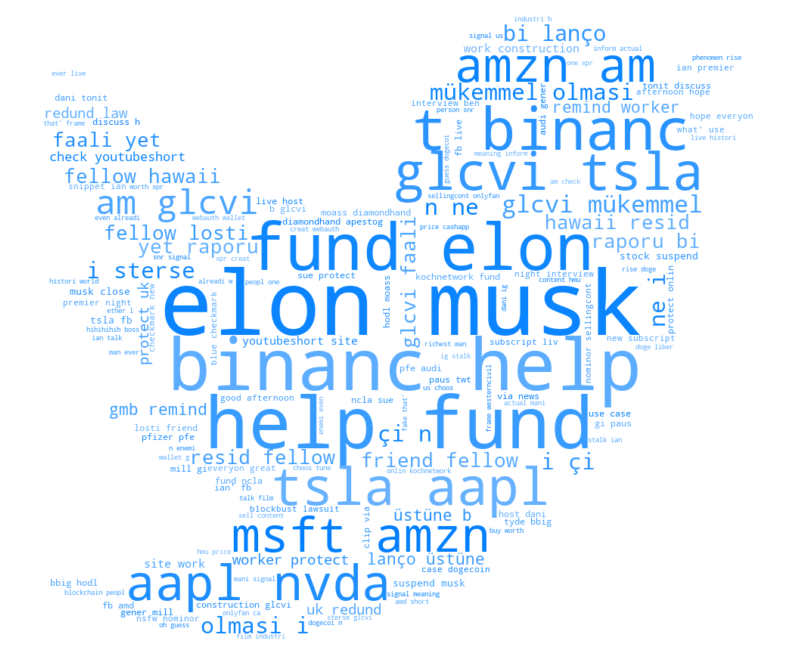

In [62]:
# word cloud generated frm tweets

skip_words = {"twitter", "twtr"}
text_tweet = df['clean_tweet'].to_string()
twitter_wc = WordCloud(background_color='white', max_words=150, stopwords=skip_words, mask=mask)
twitter_wc.generate(text_tweet)
#display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  
fig.set_figheight(18)
plt.imshow(twitter_wc.recolor(color_func=blue_color_func,random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

In [59]:
#write the processed tweet data to CsV file
df.to_csv('s3://twitter-sentiment-laks/processed/processed_tweets_TWTR_2022.csv')